# Enron Email Analysis

## Create Spark Context

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
         .appName("EnronEmailAnalysis") \
         .config("spark.some.config.option", "some-value") \
         .getOrCreate()
        
sparkctx = spark.sparkContext

## Enron Emails DataSet

The **Enron Emails DataSet** csv file was fetch from **data.world**.
The dataset has attributes such as *Message-ID*, *Date*, *Subject*, etc. The DataSet does not need any pre-processing or cleaning.

## Create DataFrame

In [2]:
dataFrame = spark.read.csv('enronEmails.csv', header=True, inferSchema=True)

## Create Initial Global Temporary View

In [3]:
dataFrame.createGlobalTempView("emailsInitial")

## Create Intermediate DataFrame

In [4]:
interDF = spark.sql("SELECT `Message-ID`, concat(split(Date, '-')[0]) as Year, concat(split(Date, '-')[1]) as Month FROM global_temp.emailsInitial")

## Create Global Temporary View from the Intermediate DataFrame

In [5]:
interDF.createGlobalTempView("emailsInter")

## Process Data

We are going to calculate the **count** of all email transactions for all the **Months** for the **Years 2000,2001**.

### Create ouput DataFrame for the Year 2000

In [6]:
year2000 = spark.sql("SELECT count(`Message-ID`), Month FROM global_temp.emailsInter WHERE Year=2000 GROUP BY Month ORDER BY Month")

year2000.show()

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|             6363|   01|
|             7185|   02|
|             8747|   03|
|             8623|   04|
|            10244|   05|
|            13701|   06|
|            13620|   07|
|            19061|   08|
|            19937|   09|
|            24716|   10|
|            32513|   11|
|            31390|   12|
+-----------------+-----+



### Create ouput DataFrame for the Year 2001

In [7]:
year2001 = spark.sql("SELECT count(`Message-ID`), Month FROM global_temp.emailsInter WHERE Year=2001 GROUP BY Month ORDER BY Month")

year2001.show()

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|            24019|   01|
|            23153|   02|
|            28513|   03|
|            35772|   04|
|            35661|   05|
|            18763|   06|
|            10202|   07|
|             8919|   08|
|            10847|   09|
|            37139|   10|
|            28607|   11|
|            11369|   12|
+-----------------+-----+



## Plots

### Lazy Imports

In [8]:
import pandas
import plotly as ply
import plotly.graph_objs as plygo

### Year 2000

In [9]:
year2000PDF = year2000.select("*").toPandas()

month = year2000PDF['Month'].tolist()
count = year2000PDF['count(Message-ID)'].tolist()

**Convert the list values of count from string to int**

In [10]:
count = list(map(int, count))

In [11]:
data = [plygo.Bar(x=month,y=count,text=count,textposition = 'outside',opacity=0.8,marker=dict(color='rgb(124,238,102)',))]

layout = plygo.Layout(yaxis = dict(range=[5000, 35000]),
                   title='Number of Enron Email Transactions Grouped Monthwise for the Year 2000',
                   font=dict(color = "black", size = 16),)

figure = plygo.Figure(data=data,layout=layout)
ply.offline.plot(figure, filename='emailTransactionsPlot_year2000.html')

'emailTransactionsPlot_year2000.html'

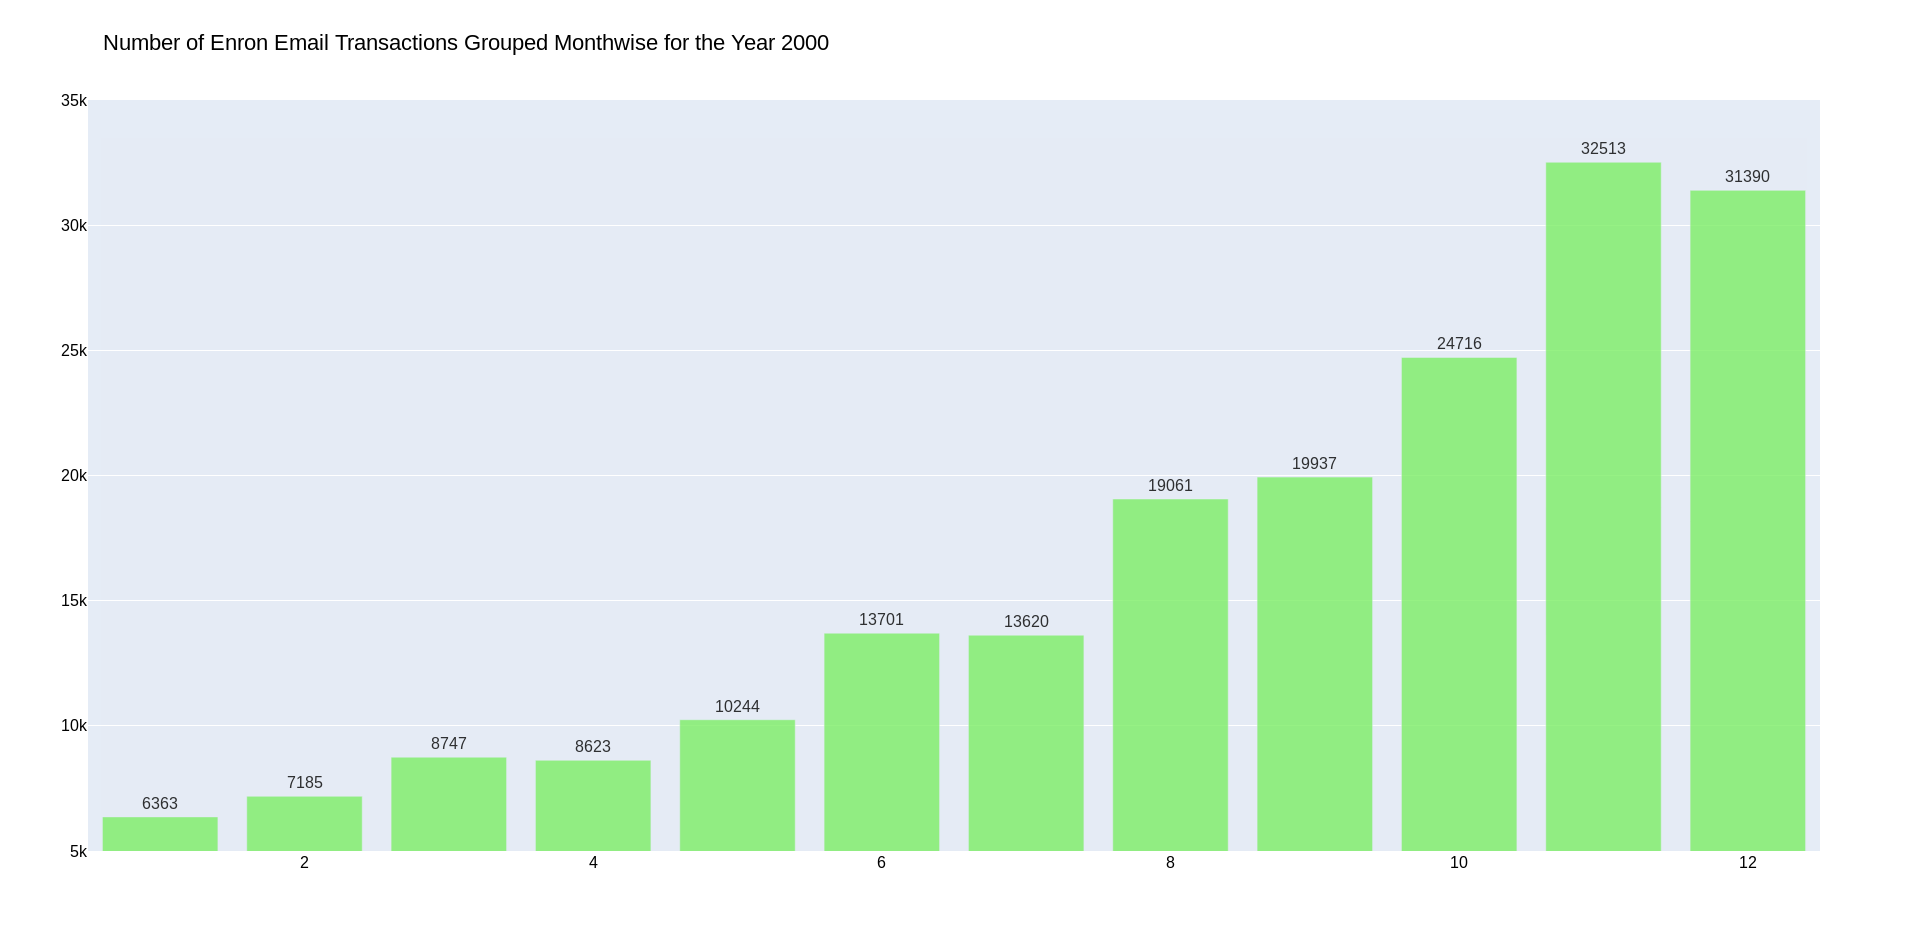

In [2]:
from IPython.display import Image

Image(filename='./emailTransactionsPlot_year2000.png', width=800, height=600)

### Year 2001

In [13]:
year2001PDF = year2001.select("*").toPandas()

month = year2001PDF['Month'].tolist()
count = year2001PDF['count(Message-ID)'].tolist()

**Convert the list values of count from string to int**

In [14]:
count = list(map(int, count))

In [15]:
data = [plygo.Bar(x=month,y=count,text=count,textposition = 'outside',opacity=0.8,marker=dict(color='rgb(124,238,102)',))]

layout = plygo.Layout(yaxis = dict(range=[8000, 40000]),
                   title='Number of Enron Email Transactions Grouped Monthwise for the Year 2001',
                   font=dict(color = "black", size = 16),)

figure = plygo.Figure(data=data,layout=layout)
ply.offline.plot(figure, filename='emailTransactionsPlot_year2001.html')

'emailTransactionsPlot_year2001.html'

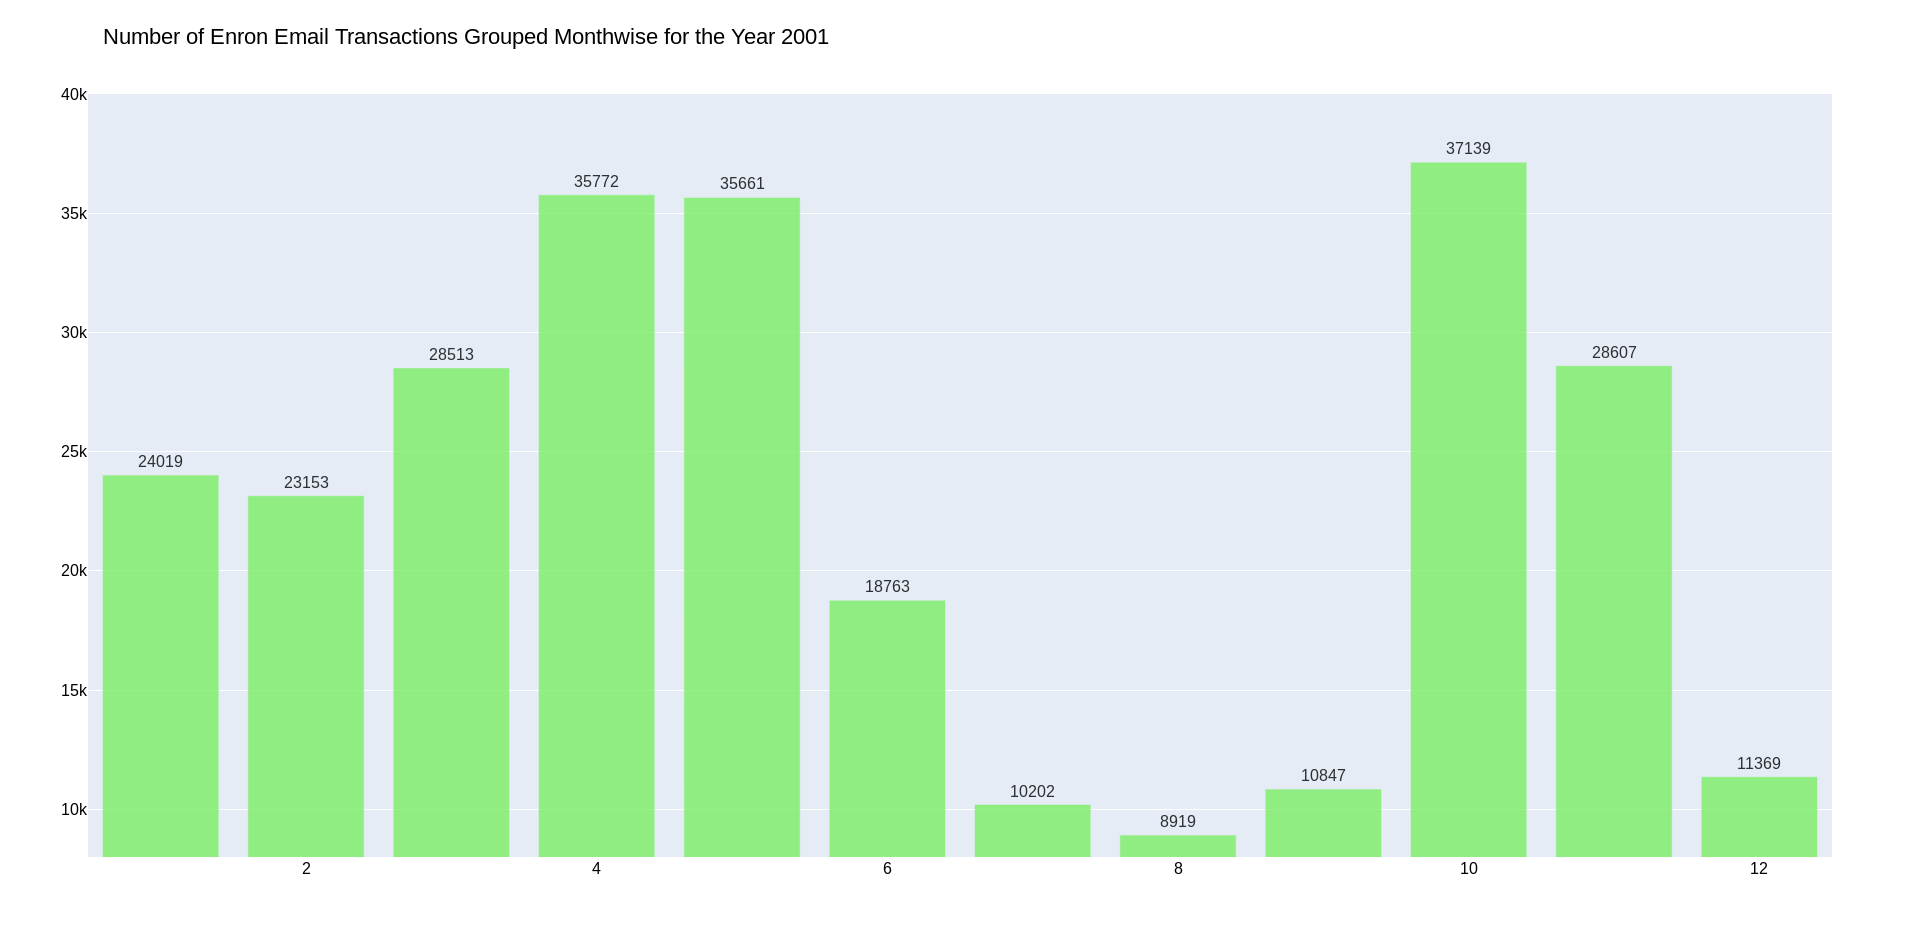

In [3]:
from IPython.display import Image

Image(filename='./emailTransactionsPlot_year2001.png', width=800, height=600)

## Scaling Test

In [17]:
import time

def processData(DF, iniGTV, finGTV):
    DF.createGlobalTempView(iniGTV)
    intermDF = spark.sql("SELECT `Message-ID`, concat(split(Date, '-')[0]) as Year, concat(split(Date, '-')[1]) as Month FROM global_temp." + iniGTV)
    intermDF.createGlobalTempView(finGTV)
    finDF2000 = spark.sql("SELECT count(`Message-ID`), Month FROM global_temp." + finGTV + " WHERE Year=2000 GROUP BY Month ORDER BY Month")
    finDF2001 = spark.sql("SELECT count(`Message-ID`), Month FROM global_temp." + finGTV + " WHERE Year=2001 GROUP BY Month ORDER BY Month")
    finDF2000.show()
    finDF2001.show()

### Synthetically Increase the Size of the DataFrame

In [18]:
# Size of DataFrame1 is 2.3 GB
dataFrame1 = dataFrame.union(dataFrame)
# Size of DataFrame2 is 4.6 GB
dataFrame2 = dataFrame1.union(dataFrame1)
# Size of DataFrame3 is 9.1 GB
dataFrame3 = dataFrame2.union(dataFrame2)
# Size of DataFrame4 is 18.2 GB
dataFrame4 = dataFrame3.union(dataFrame3)
# Size of DataFrame5 is 22.8 GB
dataFrame5 = dataFrame4.union(dataFrame2)

### Create 25 GB DataFrame

In [19]:
dataFrame25GB = dataFrame5.union(dataFrame1)

In [20]:
xVals = ['25 GB', '50 GB', '75 GB', '100 GB']
yVals = []

In [21]:
startTime = time.time()
processData(dataFrame25GB, "emails25", "final25")
endTime = time.time()
print("Time taken to process the dataframe of size 25 GB is {}".format(endTime - startTime))
timeFor25GB = endTime - startTime
yVals.append(int(timeFor25GB))

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|           139986|   01|
|           158070|   02|
|           192434|   03|
|           189706|   04|
|           225368|   05|
|           301422|   06|
|           299640|   07|
|           419342|   08|
|           438614|   09|
|           543752|   10|
|           715286|   11|
|           690580|   12|
+-----------------+-----+

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|           528418|   01|
|           509366|   02|
|           627286|   03|
|           786984|   04|
|           784542|   05|
|           412786|   06|
|           224444|   07|
|           196218|   08|
|           238634|   09|
|           817058|   10|
|           629354|   11|
|           250118|   12|
+-----------------+-----+

Time taken to process the dataframe of size 25 GB is 166.88062071800232


### Create 50 GB DataFrame

In [22]:
dataFrame50GB = dataFrame25GB.union(dataFrame25GB)

In [23]:
startTime = time.time()
processData(dataFrame50GB, "emails50", "final50")
endTime = time.time()
print("Time taken to process the dataframe of size 50 GB is {}".format(endTime - startTime))
timeFor50GB = endTime - startTime
yVals.append(int(timeFor50GB))

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|           279972|   01|
|           316140|   02|
|           384868|   03|
|           379412|   04|
|           450736|   05|
|           602844|   06|
|           599280|   07|
|           838684|   08|
|           877228|   09|
|          1087504|   10|
|          1430572|   11|
|          1381160|   12|
+-----------------+-----+

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|          1056836|   01|
|          1018732|   02|
|          1254572|   03|
|          1573968|   04|
|          1569084|   05|
|           825572|   06|
|           448888|   07|
|           392436|   08|
|           477268|   09|
|          1634116|   10|
|          1258708|   11|
|           500236|   12|
+-----------------+-----+

Time taken to process the dataframe of size 50 GB is 317.2904529571533


### Create 75 GB DataFrame

In [24]:
dataFrame75GB = dataFrame50GB.union(dataFrame25GB)

In [25]:
startTime = time.time()
processData(dataFrame75GB, "emails75", "final75")
endTime = time.time()
print("Time taken to process the dataframe of size 75 GB is {}".format(endTime - startTime))
timeFor75GB = endTime - startTime
yVals.append(int(timeFor75GB))

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|           419958|   01|
|           474210|   02|
|           577302|   03|
|           569118|   04|
|           676104|   05|
|           904266|   06|
|           898920|   07|
|          1258026|   08|
|          1315842|   09|
|          1631256|   10|
|          2145858|   11|
|          2071740|   12|
+-----------------+-----+

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|          1585254|   01|
|          1528098|   02|
|          1881858|   03|
|          2360952|   04|
|          2353626|   05|
|          1238358|   06|
|           673332|   07|
|           588654|   08|
|           715902|   09|
|          2451174|   10|
|          1888062|   11|
|           750354|   12|
+-----------------+-----+

Time taken to process the dataframe of size 75 GB is 478.9888517856598


### Create 100 GB DataFrame

In [26]:
dataFrame100GB = dataFrame75GB.union(dataFrame25GB)

In [27]:
startTime = time.time()
processData(dataFrame100GB, "emails100", "final100")
endTime = time.time()
print("Time taken to process the dataframe of size 100 GB is {}".format(endTime - startTime))
timeFor100GB = endTime - startTime
yVals.append(int(timeFor100GB))

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|           559944|   01|
|           632280|   02|
|           769736|   03|
|           758824|   04|
|           901472|   05|
|          1205688|   06|
|          1198560|   07|
|          1677368|   08|
|          1754456|   09|
|          2175008|   10|
|          2861144|   11|
|          2762320|   12|
+-----------------+-----+

+-----------------+-----+
|count(Message-ID)|Month|
+-----------------+-----+
|          2113672|   01|
|          2037464|   02|
|          2509144|   03|
|          3147936|   04|
|          3138168|   05|
|          1651144|   06|
|           897776|   07|
|           784872|   08|
|           954536|   09|
|          3268232|   10|
|          2517416|   11|
|          1000472|   12|
+-----------------+-----+

Time taken to process the dataframe of size 100 GB is 649.8856348991394


### Check Calculated Time

In [28]:
print(yVals)

[166, 317, 478, 649]


### Plot Time Elapsed

In [30]:
data = [plygo.Bar(x=xVals,y=yVals,text=yVals,textposition = 'outside',opacity=0.8,marker=dict(color='rgb(124,238,102)',))]

layout = plygo.Layout(yaxis = dict(range=[100,700]),
                   title='Time Taken to process Data of Different Sizes',
                   font=dict(color = "black", size = 16),)

figure = plygo.Figure(data=data,layout=layout)
ply.offline.plot(figure, filename='ProcessingTimeStandAloneMode.html')

'ProcessingTimeStandAloneMode.html'

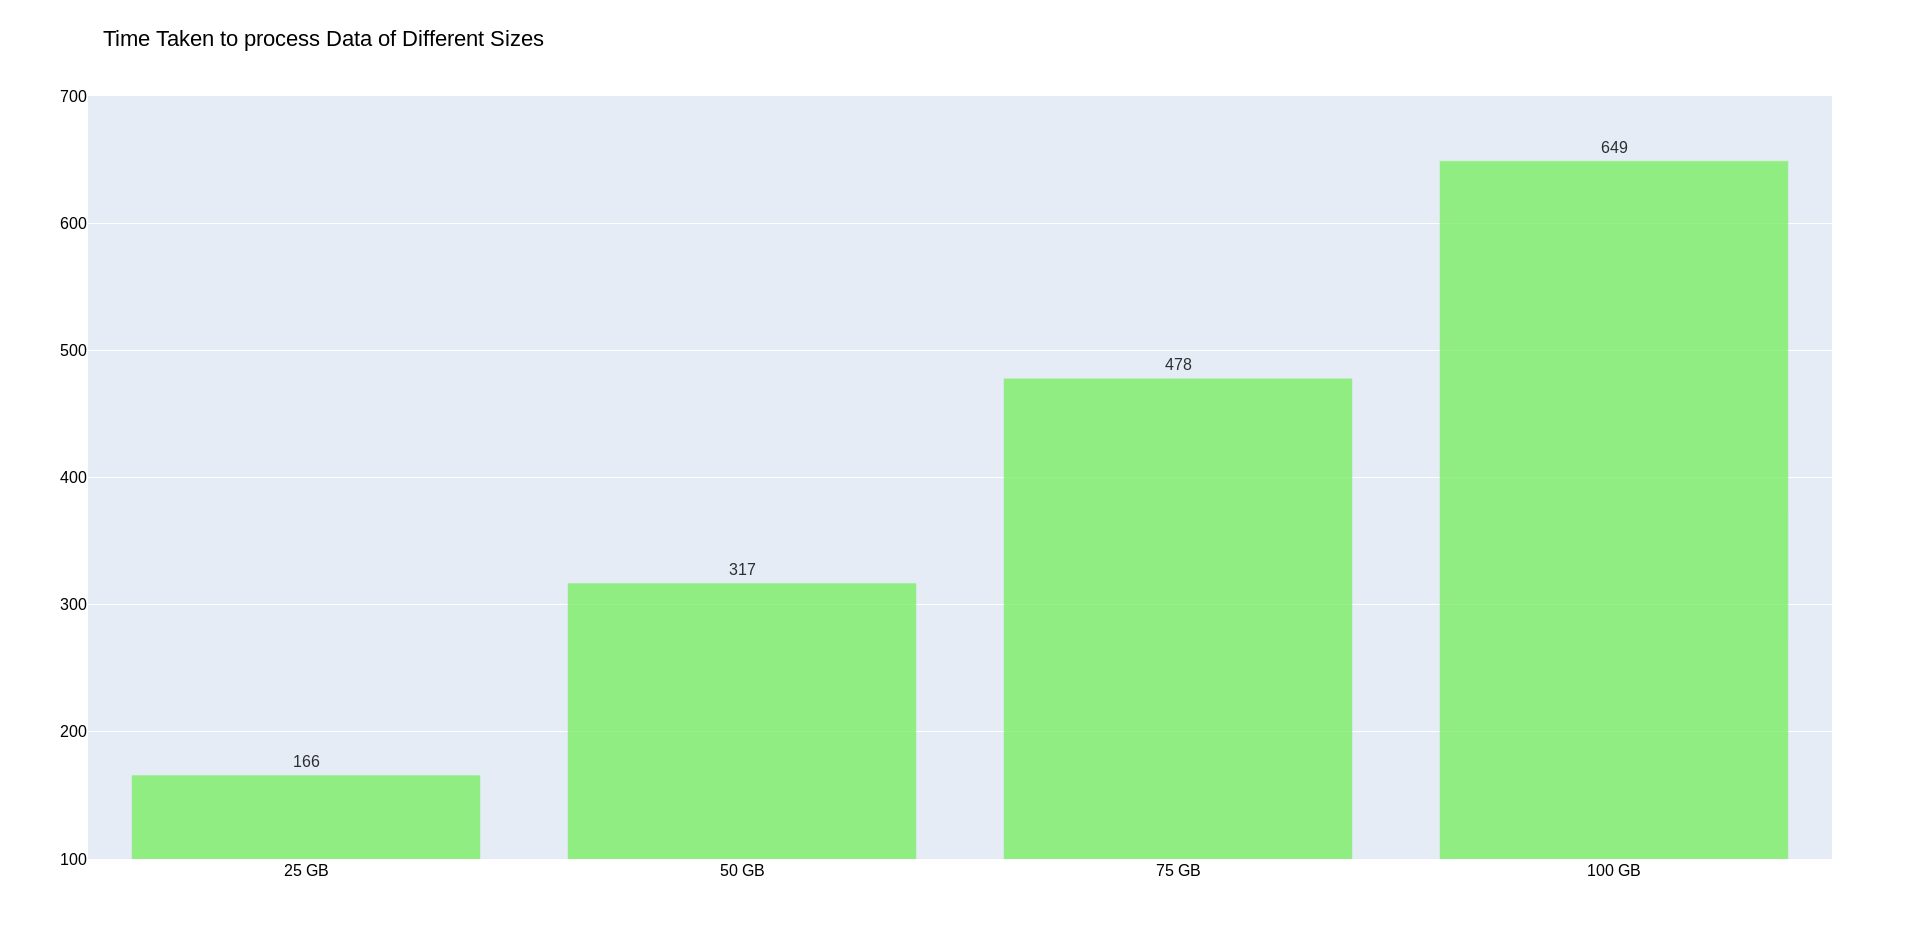

In [4]:
from IPython.display import Image

Image(filename='./ProcessingTimeStandAloneMode.png', width=800, height=600)

In [32]:
spark.stop()